# HOUSE PROJECT EDA

For the Data description see this [file](http://localhost:8888/edit/DIS_DataAnalysis/Module5/HousingProject/DATA/data_description.txt)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
filename='DATA/housing.csv'

df=pd.read_csv(filename)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Profiling

In [1]:
import pandas_profiling 

pandas_profiling.ProfileReport(df)

NameError: name 'df' is not defined

### Dealing with  Missing Value.
* Alley (93.8%)
* BsmtCond (2.5%)


* BsmtFinType1(2.5%)
* BsmtFinType2(2.6%)
* BsmbQual(2.5%)

* Fence (80.0%)
* FireplacesQu(47.3%)
* GarageCond(5.5%)
* GarageQual(5.5%)
* GarageType(5.5%)
* GarageYrBlt (5.5%)
* LotFrontaege(17.7%)
* MiscFeature (96.3%)
* PoolQc (99.5%)

Based on the results of the profiling, I remove the columns with more than 80% of NaN.

In [3]:
print("Features Before Dropping", len(df.columns))
Nrows=df['Id'].count()
for i in df.columns:
    
    if(df[i].isnull().sum()/float(Nrows))>=0.8:
        df.drop(i,axis=1,inplace=True)
        
print("Features After Dropping", len(df.columns))

Features Before Dropping 81
Features After Dropping 77


So, by dropping all the columns with more than 80% of missing data, I got 77 columns to work with.

## Filling NaN

As for the file description, there are a few columns where NAN values are using to describe the lack of certain features in the house. For example, when describing pool or garage, a NAN indicates that the house does not have a garage or a pool. So, I am going to fill these values with "No Garage". 

In [4]:
# Basement
basement=['BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF','BsmtQual']
df.loc[df['BsmtFinType1'].isnull(),basement]='No Basement'
df.loc[df['BsmtExposure'].isnull(),basement]='No Basement'
df.loc[df['BsmtFinType2'].isnull(),basement]='No Basement'
df.loc[df['BsmtQual'].isnull(),basement]='No Basement'

# Fireplace
df.loc[df['FireplaceQu'].isnull(),'FireplaceQu']='No FirePlace'

df.loc[df['GarageType'].isnull(),'GarageType']='No Garage'
df.loc[df['GarageFinish'].isnull(),'GarageFinish']='No Garage'
df.loc[df['GarageQual'].isnull(),'GarageQual']='No Garage'
df.loc[df['GarageCond'].isnull(),'GarageCond']='No Garage'
df.loc[df['GarageYrBlt'].isnull(),'GarageYrBlt']=0



## Checking NaN

In [ ]:
df.isnull().sum()[df.isnull().sum()>0]

The `LotFrontage` column has 17.7 % of missing the values.  This column describes the linear feet of street connected to property. Rather than dropping this values I am going to fill this with the mean values.
By doing a quick analysis on the data, the missing values in `LotFrontage` correspond to particoular `LandCountour` and `LotShape` (see below). So I am going to group the data using LandCountour and LotShape and then calculate the mean of each group and fill nan with that value.

In [5]:
df['LotFrontage']=df.groupby(['LandContour','LotShape'])['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

Checking if I still have Null

In [ ]:
df.isnull().sum().sum()

There are still a few columns that contains NULL

In [6]:
for c in df.columns[df.isnull().sum()>0]:
    print(c,df[c].isnull().sum())

MasVnrType 8
MasVnrArea 8
Electrical 1


Electrical describes what kind of electrical system the house has. I cannot guess this information as it is categorical, so I will assing the most common one 'SBrkr'

In [7]:
df.loc[df['Electrical'].isnull(),'Electrical']='SBrkr'

In [8]:
df['MasVnrType'].value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

`MasVnrType` describes the Masonry veneer type. The hightest number of value is None. Therefore, I will fill the nan with None.

In [9]:
df.loc[df['MasVnrType'].isnull(),'MasVnrType']='None'

`MasVnrArea` describes the Masonry veneer area in square feet. The most common value is 0. So, I will fillna with a 0.

In [10]:
df['MasVnrArea'].fillna(0,axis=0, inplace=True)

Checking number of null

In [11]:
df.isnull().sum().sum()

0

So, now there are no Null in my data.

## Plotting function

In [12]:
def varvstarget(df,feature,target):
    print(target,feature)
    data = pd.concat([df[target], df[feature]], axis=1)
    f, ax = plt.subplots(figsize=(10, 8))
    fig = sns.boxplot(x=feature, y=target, data=data)
    fig.axis(ymin=0, ymax=800000);

def joinplotfeaturevstarget(df,feature,target,kind='reg'):
    j=sns.jointplot(x=df[feature], y=df[target], kind=kind)
    j.annotate(stats.pearsonr)

# Feature separation

In the sample there are different kind of variable

In [ ]:
df.dtypes.value_counts()

There are 42 variables that are object or categorical and 32 fetures that are numerical of type int and 3 numerical of type float. I will therefore separate them into two groups and analyse them in a different way.


In [ ]:
df_num=df.select_dtypes(include=['int64','float64'])
df_cat=df.select_dtypes(include='object')

# Exploring the target variables

The database contains the variable `SalePrice`.



/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180897.73 and sigma = 79549.51

Skewness: 1.881597
Kurtosis: 6.513068


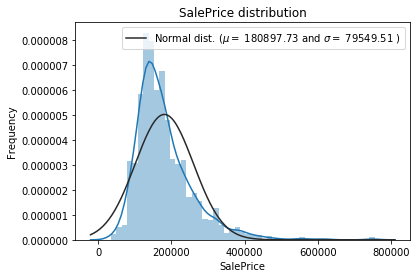

In [32]:
# Plot Histogram
from scipy.stats import norm
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())



The distribution of the `Sale Price` deviates from a Gaussian. The skewness is a positive value, so the right tail is longer and the mass of the distribution is concentrated on the left of the figure. This means that there a few houses that are sold with higher price. 

To fix this, I will use a numpy log1p to apply a log(1+x) to all the data

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = 180897.73 and sigma = 79549.51



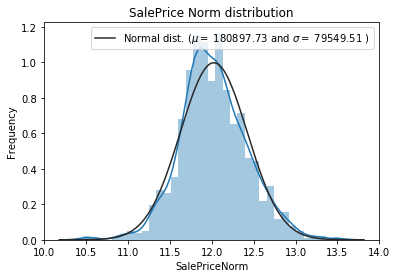

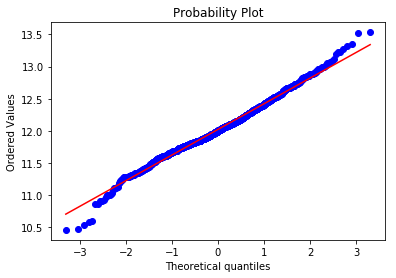

Skewness: 0.123538
Kurtosis: 0.801196


In [33]:
df["SalePriceNorm"] = np.log1p(df["SalePrice"])

#Check the new distribution 
sns.distplot(df['SalePriceNorm'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice Norm distribution')

fig = plt.figure()
res = stats.probplot(df['SalePriceNorm'], plot=plt)
plt.show()

y_train = df.SalePrice.values

print("Skewness: %f" % df['SalePriceNorm'].skew())
print("Kurtosis: %f" % df['SalePriceNorm'].kurt())

## Analyse Numerical Feature

### Correlation Matrix

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_num.corr(),annot=True)

Some of the features can be grouped together into a new feature that combine their values. For example, the number of bedrom above and below the ground or the number of bath (full and half) as well as the living are in sq foot. 

All these variable can be grouped into:
* Total number of Bathroom: sum of full bath above and below and half bathroom
* Total number of living area: this will have the total area of the properties that include the sum of the ground living area, lot area although I am not sure if this feature already describe the total area. I will first check if so and if not, I will calculate the total area.

# Bathroom

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


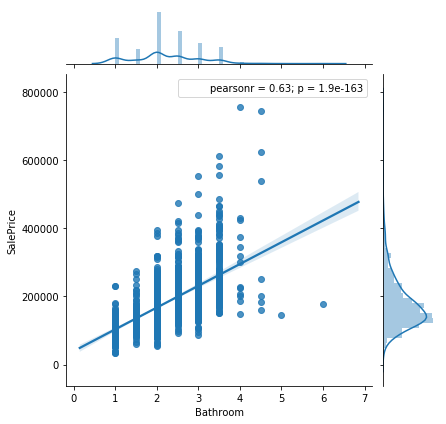

In [13]:
df['Bathroom']=df['BsmtFullBath']+df['FullBath']+0.5*df['BsmtHalfBath']+0.5*df['HalfBath']
joinplotfeaturevstarget(df,'Bathroom','SalePrice',kind='reg')
df=df.drop(df[(df['Bathroom']>4) 
                         & (df['SalePrice']<300000)].index).reset_index(drop=True)
df.drop(df[['BsmtFullBath','FullBath','BsmtHalfBath','HalfBath']],axis=1,inplace=True)



/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


0.6470755467651792


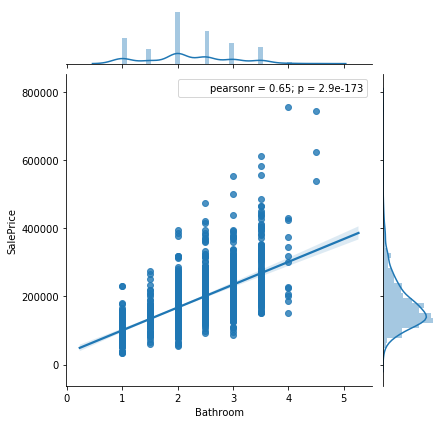

In [20]:
joinplotfeaturevstarget(df,'Bathroom','SalePrice',kind='reg')
print(df['Bathroom'].corr(df['SalePrice']))
#df.drop([['TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','PoolArea','OpenPorchSF']+df['EnclosedPorch']+df['ScreenPorch']+df['MasVnrArea']

There is 68% correlation between Sale Price Norm and number of bathrooms, while the correlation with the original Sale price is 64%.

# LivingArea

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


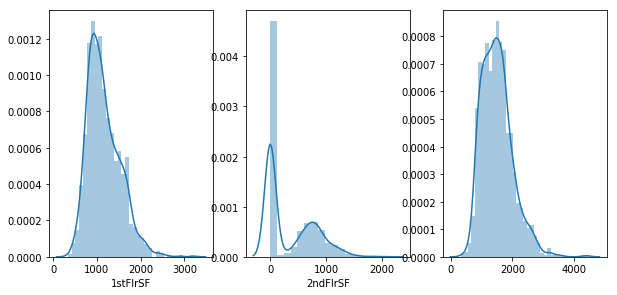

In [25]:
plt.figure(figsize=(10,10))
plt.subplot(231)
sns.distplot(df['1stFlrSF'])
plt.subplot(232)
sns.distplot(df['2ndFlrSF'])
plt.subplot(233)
sns.distplot(df['1stFlrSF']+df['2ndFlrSF'])



/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


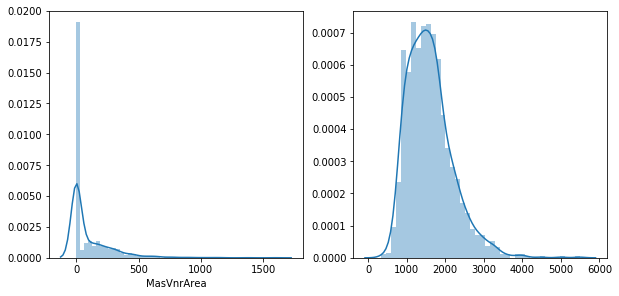

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.distplot(df['MasVnrArea'])
plt.subplot(222)
sns.distplot(df['MasVnrArea']+df['1stFlrSF']+df['2ndFlrSF'])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


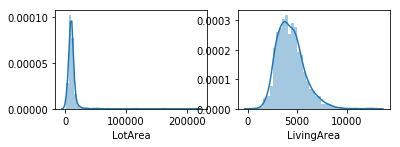

In [23]:
plt.subplot(221)
sns.distplot(df['LotArea'])
plt.subplot(222)
df['LivingArea']=df['MasVnrArea']+df['1stFlrSF']+df['2ndFlrSF']+df['TotalBsmtSF']+df['GrLivArea']+df['WoodDeckSF']+df['OpenPorchSF']+df['EnclosedPorch']+df['3SsnPorch']+df['PoolArea']
sns.distplot(df['LivingArea'])





/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


0.2678648551260439
0.8373778940925282


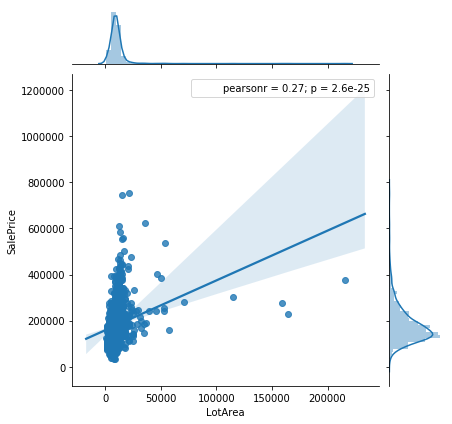

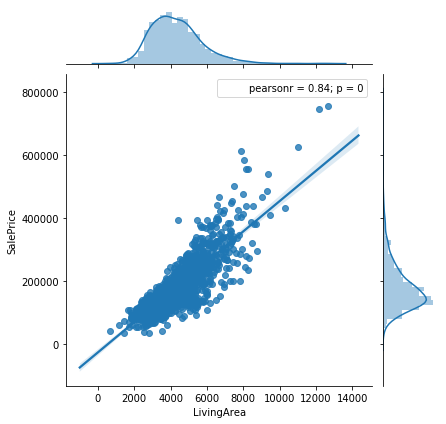

In [25]:
joinplotfeaturevstarget(df,'LotArea','SalePrice',kind='reg')
print(df['LotArea'].corr(df['SalePrice']))
joinplotfeaturevstarget(df,'LivingArea','SalePrice',kind='reg')
print(df['LivingArea'].corr(df['SalePrice']))



Lot area has a 26% correlation with the sale price, but the new variable 'LivingArea' has a 84%correlation with Saledata

# Check OverallQual

This is a weird features as it is numerical but it is more categorical. I will deal with this later.


SalePrice OverallQual


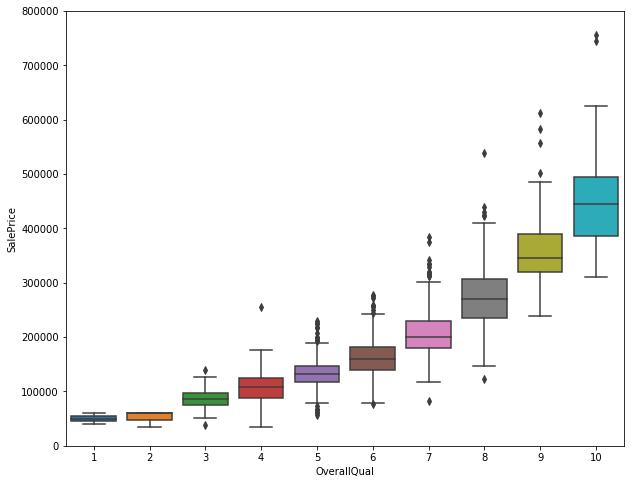

In [26]:
varvstarget(df,'OverallQual','SalePrice')

So here  the overall quality and the sale price has an exponential relation.

In [28]:
df[['OverallQual','OverallCond','SalePrice']].corr()

,OverallQual,OverallCond,SalePrice
OverallQual,1.000000,-0.090223,0.796172
OverallCond,-0.090223,1.000000,-0.077268
SalePrice,0.796172,-0.077268,1.000000


# Time Variable

In [ ]:
plt.scatter(df['YearBuilt'],df['SalePrice'],s=100,c=np.abs(df['YearRemodAdd']-df['YrSold']),cmap='viridis')
plt.colorbar()

SalePrice Renovation


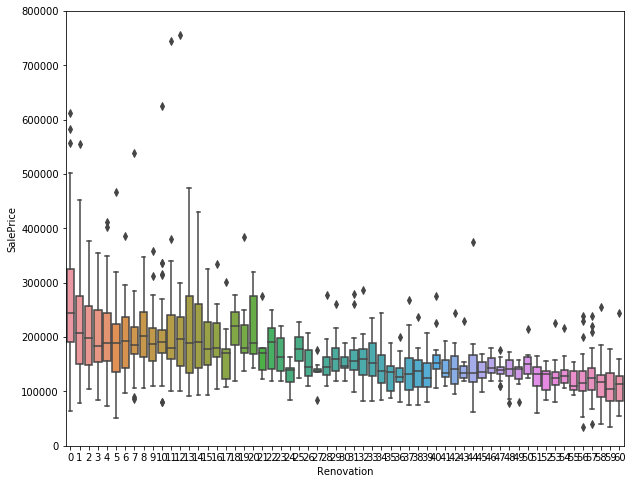

In [29]:
df['Renovation']=df['YrSold']-df['YearRemodAdd']
varvstarget(df,'Renovation','SalePrice')

When Renovation is 0 its means that the house has been sold in the same year of renovation.

In [34]:
df[['Renovation','OverallQual','SalePrice','SalePriceNorm']].corr()

,Renovation,OverallQual,SalePrice,SalePriceNorm
Renovation,1.000000,-0.552594,-0.510693,-0.569708
OverallQual,-0.552594,1.000000,0.796172,0.822158
SalePrice,-0.510693,0.796172,1.000000,0.948395
SalePriceNorm,-0.569708,0.822158,0.948395,1.000000


As expected, there is a high correlation or anticorrelation between SalePrice and Renovation, as well as between OverallQuality and Renovation. 

SalePrice BsmtFinType1


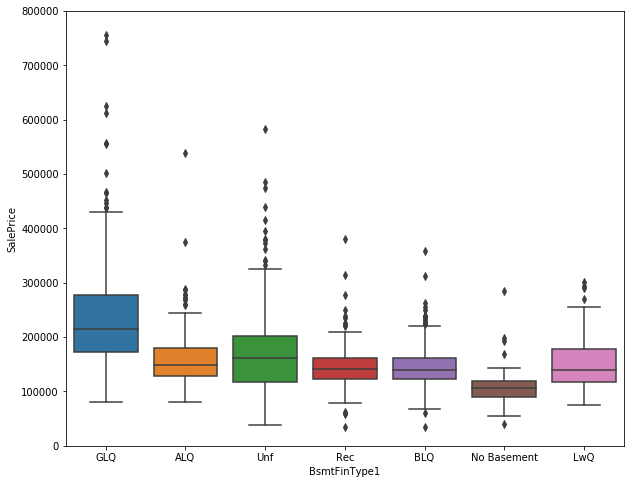

In [35]:
varvstarget(df,'BsmtFinType1','SalePrice')

In [ ]:
varvstarget(df,'Foundation','SalePrice')

SalePrice RoofStyle


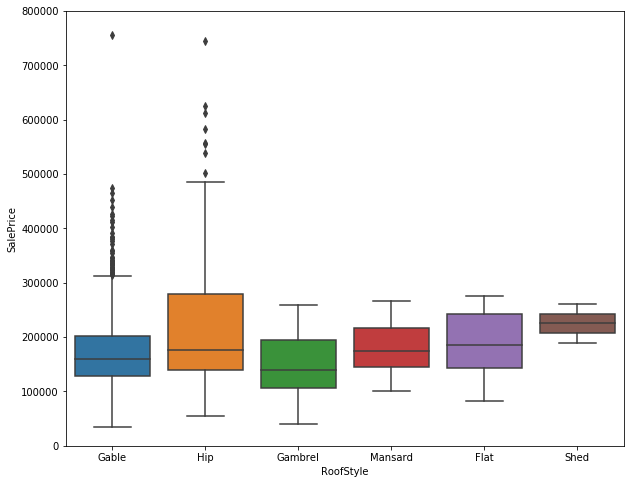

In [36]:
varvstarget(df,'RoofStyle','SalePrice')

SalePrice HeatingQC


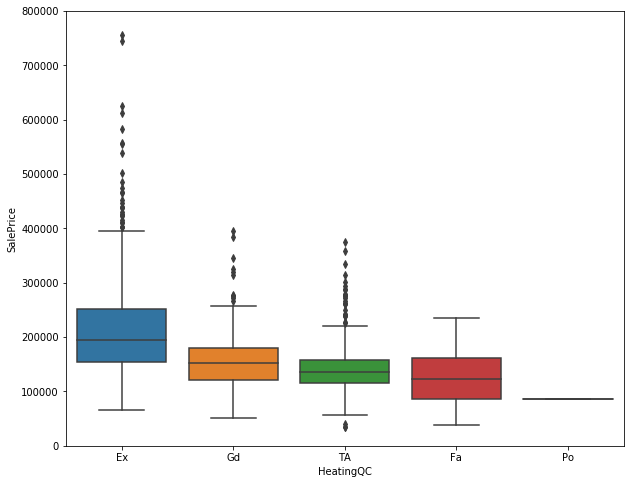

In [38]:
varvstarget(df,'HeatingQC','SalePrice')

SalePrice Heating


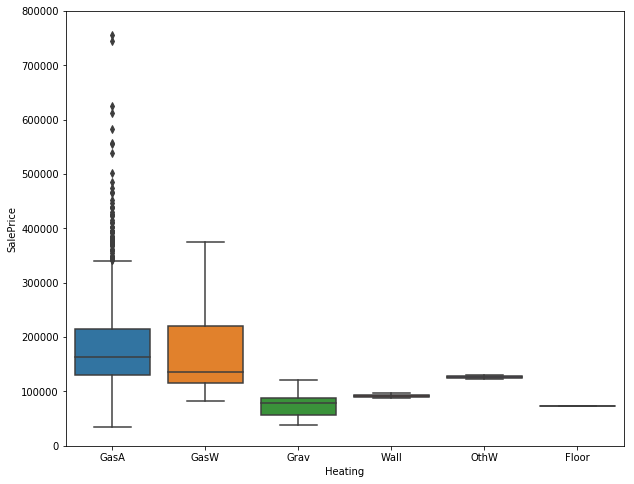

In [37]:
varvstarget(df,'Heating','SalePrice')

Trasform into a Flag Gas=1 others=0.

SalePrice CentralAir


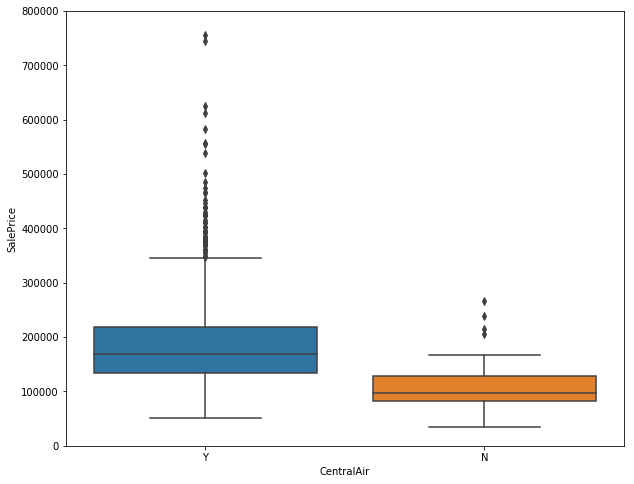

In [39]:
varvstarget(df,'CentralAir','SalePrice')


Trasform Yes=1 N=0

SalePrice Electrical


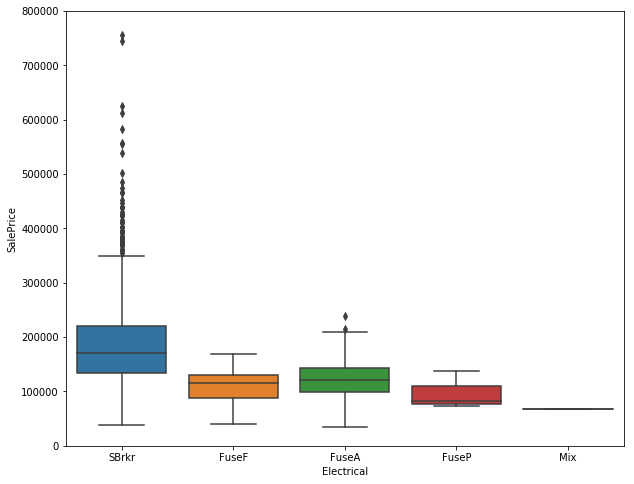

In [40]:
#df[df['Electrical']=='Not Given']='SBrkr'
varvstarget(df,'Electrical','SalePrice')
#df['Electrical'].value_counts()

Mix has to few values so transform them as not

SalePrice KitchenQual


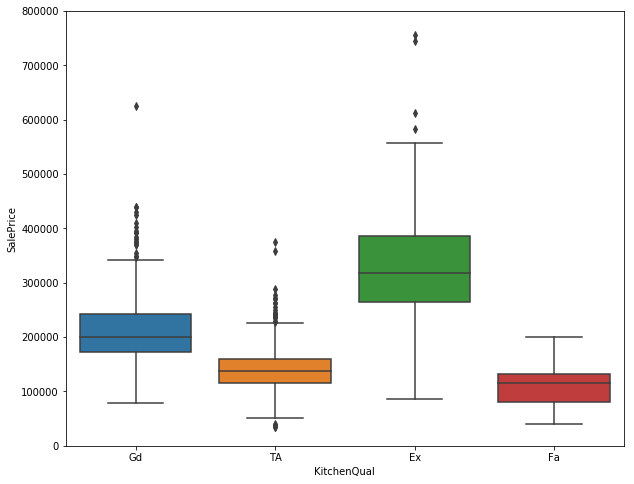

In [41]:
varvstarget(df,'KitchenQual', 'SalePrice')

SalePrice KitchenAbvGr


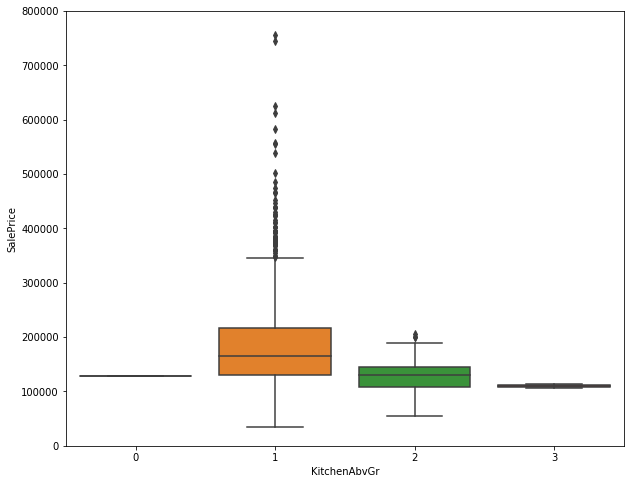

In [42]:
varvstarget(df,'KitchenAbvGr', 'SalePrice')

SalePrice Utilities


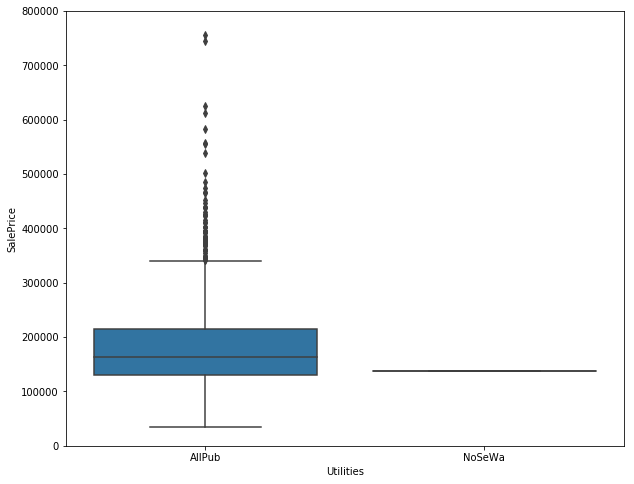

In [44]:
varvstarget(df,'Utilities', 'SalePrice')

CheckinJg Normality of feature

In [45]:

for c in df.select_dtypes(include=['float64']).columns:
    if c!= 'Bathroom' and c != 'SalePriceNorm':
        print(c," Skewness: %f" % df[c].skew(),"Kurtosis: %f" % df[c].kurt())



LotFrontage  Skewness: 1.582910 Kurtosis: 13.677575
MasVnrArea  Skewness: 2.700739 Kurtosis: 10.440246
GarageYrBlt  Skewness: -3.917486 Kurtosis: 13.419679
LivingArea  Skewness: 0.974684 Kurtosis: 2.200534


LotFrontage and MasVnrArea are not Gaussian.

In [ ]:
def normvar(df, column):
    print("Skewness: %f" % df[column].skew())
    print("Kurtosis: %f" % df[column].kurt())

    plt.subplot(2,2,1)
    sns.distplot(df[column] , fit=norm);
    plt.subplot(2,2,2)
    sns.distplot(np.log1p(df[column]) , fit=norm);
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(np.log1p(df[column]))
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
    plt.ylabel('Frequency')
    plt.title(' Norm distribution')

    fig = plt.figure()
    res = stats.probplot(df[column], plot=plt)
    plt.show()
    print("Skewness: %f" % np.log1p(df[column].skew()))
    print("Kurtosis: %f" % np.log1p(df[column].kurt()))


In [ ]:
normvar(df, 'LotFrontage')

In [ ]:
normvar(df, 'LivingArea')



# Mapping Categorical variable

In [ ]:
df_copy = df.copy()

In [46]:
def mapping(df,col_to_map,m=list(),verbose=False):
    v=df[col_to_map].value_counts().reset_index()
    if not m:
        v['map']=np.arange(v['index'].count())
    else:
        v['map']=m
    mymap={}

    for k,c in zip(v['index'],v['map']):
        mymap[k]=c
    if(verbose):
        print(mymap)
    return df[col_to_map].map(mymap)

# Saving New DF with only chosen feature

In [ ]:
df.columns

In [47]:
feature=['Id', 'MSSubClass', 'MSZoning', 'KitchenQual',
         'BsmtFinType1','Foundation','HouseStyle','Neighborhood','Bathroom','LivingArea',
        'OverallQual','OverallCond','Renovation','GarageCars','Foundation','RoofStyle','BldgType','HeatingQC','Electrical',
        'YrSold','MoSold','SalePrice','BedroomAbvGr']
newdf=pd.DataFrame(df[feature],columns=feature)
newdf['SalePriceNorm']=np.log1p(newdf['SalePrice'])
newdf['Heating']=mapping(df,'Heating',m=[1, 1, 0, 0, 0, 0])
newdf['CentralAir']= mapping(df,'CentralAir',m=[1,0])   
newdf['Pool']=mapping(df,'PoolArea',m=[0, 1, 1, 1, 1, 1])

In [48]:
newdf.to_csv('Houseing_choosen_feature.csv',index=False)

Selecting training file

In [49]:
newdf[newdf['YrSold']==2010].to_csv('Testing_housing.csv',index=False)
newdf[newdf['YrSold']!=2010].to_csv('Training_housing.csv',index=False)

# Try Recursive Feature Selection with LogisticRegression

Not Used.

In [ ]:
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
target_col='SalePrice'
feature_cols = [c for c in df.columns if c != target_col]
X=pd.DataFrame(df[feature_cols])
y=df[target_col]
lab_enc = preprocessing.LabelEncoder()
y_scores_encoded = lab_enc.fit_transform(y)

# feature extraction
model = LogisticRegression()
rfe = RFE(model, 8)
fit = rfe.fit(X,y_scores_encoded)
